# Wykorzystanie testów istotności statystycznej do porównania wyników modeli uczenia maszynowego

Niniejszy notatnik jest inspirowany dwoma wpisami Jasona Brownlee: 
- [How to Use Statistical Significance Tests to Interpret Machine Learning Results](https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/)
- [Statistical Significance Tests for Comparing Machine Learning Algorithms](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/)

oraz pracą magisterską Krzysztofa Dobosza:
- [Statystyczne testy oceny istotności różnic w wynikach uzyskiwanych przez różne systemy uczące się](http://fizyka.umk.pl/publications/kmk/Prace-Mgr/Krzysztof%20Dobosz%20-%20Praca%20magisterska.pdf)

# Opis problemu

Załóżmy, że w [czasie prac](https://github.com/mariuszrokita/machine-learning-model-deployment/blob/master/ModelDevelopment/Titanic.ipynb) udało nam się stworzyć dwa modele uczenia maszynowego. Jakość obu modelów została oszacowana poprzez zastosowanie K-krotnej walidacji krzyżowej.

Wyniki *accuracy* dla obu modeli są następujące:

**Model A:**

`[0.734375, 0.82539683, 0.88709677, 0.82258065, 0.67741935, 
0.70967742, 0.79032258, 0.77419355, 0.80645161, 0.90322581]`

Mean: 0.7930739567332309, STD: 0.06870856655624873

**Model B:**

`[0.796875, 0.79365079, 0.88709677, 0.85483871, 0.80645161, 
0.75806452, 0.80645161, 0.80645161, 0.74193548, 0.91935484]`

Mean: 0.8171170954941116, STD: 0.05216682941303683

**Pytanie:** 

Czy wyniki jednego i drugiego modelu różnią się istotnie od siebie?

# Analiza uzyskanych wyników

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

## Załadowanie danych

In [2]:
results = pd.DataFrame()

# performance results for model A
results['A'] = [0.734375, 0.82539683, 0.88709677, 0.82258065, 0.67741935, 
                0.70967742, 0.79032258, 0.77419355, 0.80645161, 0.90322581]
# performance results for model B
results['B'] = [0.796875, 0.79365079, 0.88709677, 0.85483871, 0.80645161, 
                0.75806452, 0.80645161, 0.80645161, 0.74193548, 0.91935484]

results

,A,B
0,0.734375,0.796875
1,0.825397,0.793651
2,0.887097,0.887097
3,0.822581,0.854839
4,0.677419,0.806452
5,0.709677,0.758065
6,0.790323,0.806452
7,0.774194,0.806452
8,0.806452,0.741935
9,0.903226,0.919355


## Analiza wyników

In [3]:
stats = results.describe()
stats

,A,B
count,10.000000,10.000000
mean,0.793074,0.817117
std,0.072425,0.054989
min,0.677419,0.741935
25%,0.744330,0.794457
50%,0.798387,0.806452
75%,0.824693,0.842742
max,0.903226,0.919355


Patrząc na wartości średnie możemy stwierdzić, że:
* przeciętnie model B (0.817117) jest lepszy od modelu A (0.793074). 
* w obu przypadkach średnie odchylenia wyników od średniej arytmetycznej (czyli odchylenie standardowe) są bardzo zbliżone i wynoszą: 0.054989 dla modelu B oraz 0.072425 dla modelu A.
* Mediana (50-ty percentyl) obu rozkładów jest bardzo podobna.

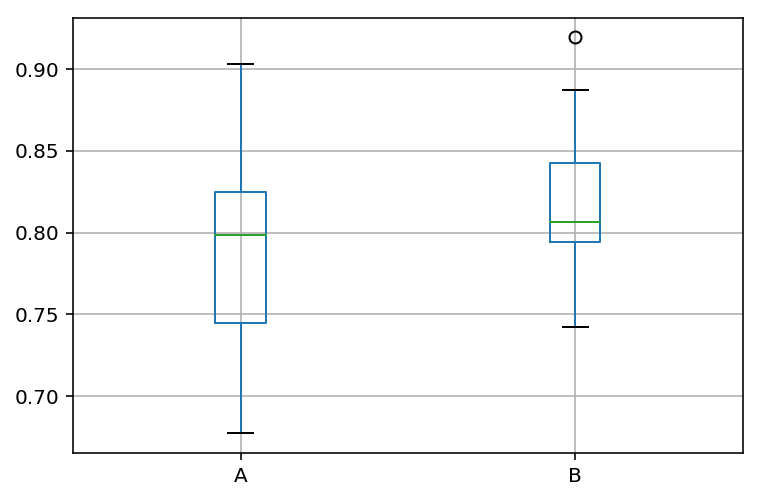

In [4]:
results.boxplot();

In [5]:
IQR = stats.loc["75%"] - stats.loc["25%"]
IQR

A    0.080363
B    0.048285
dtype: float64

Analizując wykres pudełkowy (inne nazwy to: *wykres ramka-wąsy*, *box plot*, *whisker plot*) możemy stwierdzić, że:
* wyniki modelu B są bardziej skupione wokół średniej. Wartość rozstępu międzykwartylowego (różnica między trzecim a pierwszym kwartylem) dla modelu A wynosi 0.080363 i jest prawie dwukrotnie większa niż dla modelu B (0.048285).
* model A uzyskał mniejszą wartość minimalną oraz wyższą wartość maksymalną od modelu B (nie uwzględniając wartości nietypowej).
* rozkład wyników modelu B w dużym stopniu pokrywa się z rozkładem wyników dla modelu A.

# Problem wyboru lepszego modelu

Wybór lepszego modelu jest bardzo częstą operacją. W końcu przecież trenujemy wiele modeli, wiele algorytmów z różnymi wartościami hiperparametrów tylko po to, by znaleźć najlepszy model i później go wykorzystać, np. do wdrożenia na produkcję.

Mamy jednak pewien kłopot z porównywaniem wyników i stwierdzeniem, który model jest rzeczywiście lepszy. Przykładowo - porównując wyniki dwóch modeli - nie wiemy, czy różnica w wynikach obu modeli jest statystycznie istotna, czy też jest dziełem przypadku.

Oczywiście mając więcej dostępnego czasu moglibyśmy uruchomić modele większą ilość razy. Uzyskalibyśmy w ten sposób więcej wyników zmniejszając ich przypadkowość. Zazwyczaj jednak jest to biznesowo niemożliwe, bo czas nas goni, a dodatkowo modele długo się trenują (np. sieć neuronowa trenująca się dwa dni).

W wyborze najlepszego modelu oraz jego ocenie mogą pomóc nam testy statystyczne.

## Wstęp do testowania hipotez

Stosując najpopularniejszą 10-krotną walidację krzyżową dla każdego modelu dostajemy próbę z 10-cioma wartościami funkcji kosztu. Niestety, zazwyczaj w takiej sytuacji nie jest znany rozkład tych wyników (rozkład normalny lub inny), a jest to ważne, bo decyduje o rodzaju testów, które można wykorzystać (parametryczne, nieparametryczne).

Ze względu na to, że próba ta jest nie jest zbyt liczna, tj. zawiera mniej niż 30 elementów, nie możemy skorzystać z Centralnego Twierdzenia Granicznego i jego przybliżenia, że rozkład średnich z wyników jest zbliżony do rozkładu normalnego oraz że uzyskana próbka rezultatów pochodzi z rozkładu normalnego.

Jest jeszcze inny problem - testy statystyczne istotności zakładają, że zaobserwowane wartości zostały uzyskane w sposób losowy, niezależny. W przypadku $k$-krotnej walidacji krzyżowej warunek ten nie jest niestety spełniony, bo dany wektor cech bierze udział w trenowaniu modelu $k-1$ razy (a raz jest częścią zbioru testowego i służy do oceny modelu), a tym samym ma wpływ na $k-1$ uzyskanych wyników jakości modelu. 

Można to też ująć inaczej - dla najpopularniejszej 10-krotnej walidacji krzyżowej, zbiory treningowe w dwóch kolejnych iteracjach mają wspólne $\frac{8}{9}=88.9\%$ danych: 
<img src="./assets/10-cv.png" style="width:50%" />

W praktyce, warunek niezależności jest często pomijany.

## Wyliczenie statystyki

Wybór odpowiedniego testu statystycznego można w dużym uproszczeniu ująć następująco:

1. jeśli wektor wyników z n < 30, to
    1. test t-Studenta lub
    1. test Wilcoxona lub
    1. test Welcha
1. jeśli wektor wyników z n >= 30
    1. test t-Studenta

### Test t-Studenta, Test t-Welcha

Test t-Studenta jest testem parametrycznym i służy do porównywania wartości **średnich** z badanych próbek oraz do tego, by stwierdzić jak bardzo **istotna** jest różnica pomiędzy tymi średnimi. 

Test t-Studenta zakłada, że populacje mają tę samą wariancję, natomiast test t-Welcha uogólnia ten przypadek na populacje o różnych wariancjach.

W teście tym hipotezy wyglądają następująco:

* H<sub>0</sub>: obie populacje mają **równe** wartości średnie (oczekiwane)
* H<sub>A</sub>: obie populacje mają **różne** wartości średnie (oczekiwane)

W pierwszym kroku musimy upewnić się, że dane mają rozkład normalny (założenie obu testów). By to zrobić wykorzystamy test Shapiro-Wilka, o którym pisałem w innym notatniku [normality-tests](normality-tests.ipynb).

In [6]:
def shapiro_wilk_test(data, alpha=0.05):
    from scipy import stats
    
    statistic, pvalue = stats.shapiro(data)
    print("Statistic={:.4f}, p-value={}".format(statistic, pvalue))
    if pvalue > alpha:
        print("Sample looks Gaussian (fail to reject H0)")
        return True
    else:
        print("Sample does not look Gaussian (reject H0)")
        return False

print("Próbka A")
shapiro_wilk_test(results['A']);
print()
print("Próbka B")
shapiro_wilk_test(results['B']);

Próbka A
Statistic=0.9702, p-value=0.892608642578125
Sample looks Gaussian (fail to reject H0)

Próbka B
Statistic=0.9235, p-value=0.3867448568344116
Sample looks Gaussian (fail to reject H0)


W drugim kroku musimy się dowiedzieć, czy wariancje obu próbek są takie same. Do tego celu wykorzystamy [test Levene'a](https://en.wikipedia.org/wiki/Levene%27s_test) - jego H<sub>0</sub> to: wszystkie próbki pochodzą z populacji o tej samej wariancji.

In [7]:
from scipy import stats

def levine_test(data1, data2, alpha=0.05):
    from scipy import stats
    
    statistic, pvalue = stats.levene(data1, data2)
    print(f"Statistic={statistic:.4f}, p-value={pvalue:.4f}")
    if pvalue > alpha:
        print("Equal variances (fail to reject H0)")
        return True
    else:
        print("We have no equal variances (reject H0)")
        return False

equal_var = levine_test(results['A'], results['B'])
print(equal_var)

Statistic=0.9761, p-value=0.3363
Equal variances (fail to reject H0)
True


Na podstawie testu Levene'a możemy stwierdzic, że obie próbki danych mają tę samą wariancję, a więc moglibyśmy skorzystać z testu t-Studenta. Jednak dla celów edukacyjnych stwierdzę, że wartości wariancji, a przez to wartości wyliczonych odchyleń standardowych 0.054989 (model B) oraz 0.072425 (model A) są różne. Wówczas będę mógł skorzystać z uogólnionego testu t-Welcha.

W naszym przykładzie wyliczenie statystyki $t$ oraz $p-value$ powinno wyglądać następująco:

In [8]:
from scipy import stats
t_value, p_value = stats.ttest_ind(results['A'].values, 
                                   results['B'].values, 
                                   equal_var=False)

print(f"t-test statistic: {t_value:.6f}")
print(f"p-value: {p_value:.6f}")

t-test statistic: -0.836104
p-value: 0.414839


Ze względu na to, że wartość $p-value$ jest większa od domyślnego poziomu istotności $\alpha=0.05$, nie mamy podstaw, by odrzucić hipotezę zerową H<sub>0</sub>. 

**KONKLUZJA: nie mamy podstaw do tego by stwierdzić, że wyniki modelu B są statystycznie istotnie lepsze od wyników modelu A.**

#### Obliczenia sprawdzające

Wyliczmy samodzielnie wartość statystyki t-Welcha [Wikipedia](https://pl.wikipedia.org/wiki/Test_t_Welcha):

In [9]:
a_mean = results['A'].mean()
b_mean = results['B'].mean()

a_var = results['A'].var()
b_var = results['B'].var()

a_N = len(results['A'])
b_N = len(results['B'])

# calculate the t-statistic
t = (a_mean - b_mean) / np.sqrt( (a_var/a_N) + (b_var/b_N) )
print(f"Welch's t-test: {t:.4f}")

# calculate degrees of freedom using approximation
def welch_dof(x, y):
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    return dof

dof = welch_dof(results['A'], results['B'])
p = 2 * stats.t.cdf(t, df=dof)
print(f"p-value: {p:.4f}")

Welch's t-test: -0.8361
Welch-Satterthwaite Degrees of Freedom= 16.7882
p-value: 0.4148


#### Interpretacja graficzna

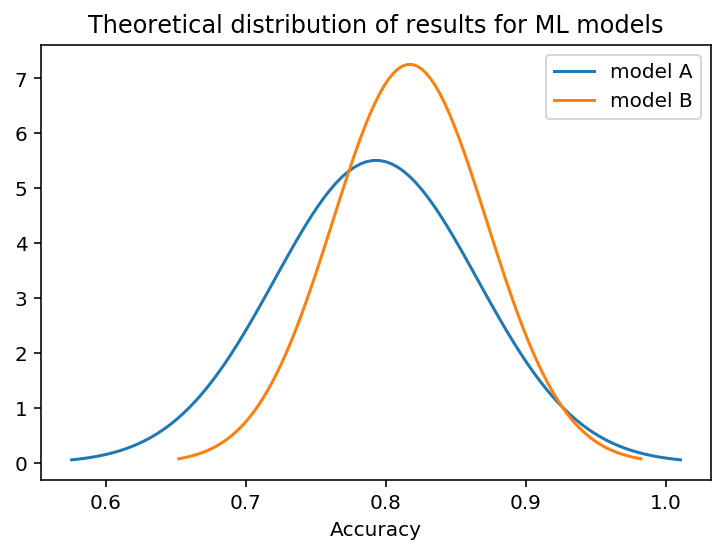

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Gaussian distribution for results for model A
mu = 0.793074
std = 0.072425
x1 = np.linspace(mu - 3*std, mu + 3*std, 100)
y1 = stats.norm.pdf(x1, mu, std)
plt.plot(x1, y1, label='model A')

# Gaussian distribution for results for model B
mu = 0.817117
std = 0.054989
x2 = np.linspace(mu - 3*std, mu + 3*std, 100)
y2 = stats.norm.pdf(x2, mu, std)
plt.plot(x2, y2, label='model B')

plt.title("Theoretical distribution of results for ML models")
plt.xlabel("Accuracy")
plt.gca().legend()
plt.show()

### Test Wilcoxona 

# Raport końcowy

Niniejsza analiza miała na celu sprawdzenie, czy wyniki jakości (*accuracy*) modelu A i modelu B różnią się istotnie od siebie.

Na podstawie 10 obserwacji (wyniki 10-krotnej walidacji krzyżowej) każdego z modelów można stwierdzić, że model B uzyskiwał troszkę lepsze wyniki (M=0.817117, SD=0.054989) od modelu A (M=0.793074, SD=0.072425). 

Do oceny istotności różnicy wyników został wykorzystany test Welcha, aczkolwiek test Levene'a (W=0.9761, p-value=0.3363) wskazał, że obie próbki mają tę samą wariancję i można użyć test t-Studenta.

Wyniki testu t-Welcha (T=-0.8361, dof=16.7882,p-value=0.4148) wskazują, że różnica w wynikach modelu A i modelu B nie są istotne statystycznie.